In [1]:
using Keldysh; kd = Keldysh
using KeldyshED; ked = KeldyshED; op = KeldyshED.Operators;

using WoodburyMatrices

using Interpolations: inner_system_diags, lut!
import Interpolations: prefiltering_system

using QInchworm.spline_gf: SplineInterpolatedGF

using PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

LoadError: ArgumentError: Package Keldysh not found in current path:
- Run `import Pkg; Pkg.add("Keldysh")` to install the Keldysh package.


In [62]:
function prefiltering_system(::Type{T}, ::Type{TC}, n::Int, degree::Quadratic{<:Line}) where {T,TC}
    dl,d,du = inner_system_diags(T,n,degree)
    d[1] = d[end] = 1
    du[1] = dl[end] = -2
    @show d

    specs = WoodburyMatrices.sparse_factors(T, n,
                                  (1, 3, oneunit(T)),
                                  (n, n-2, oneunit(T)),
                                  )
    
    b = zeros(TC, n)
    b[1] = 0
    b[end] = 0

    Woodbury(lut!(dl, d, du), specs...), b
end

prefiltering_system (generic function with 14 methods)

d = [1.0, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 1.0]


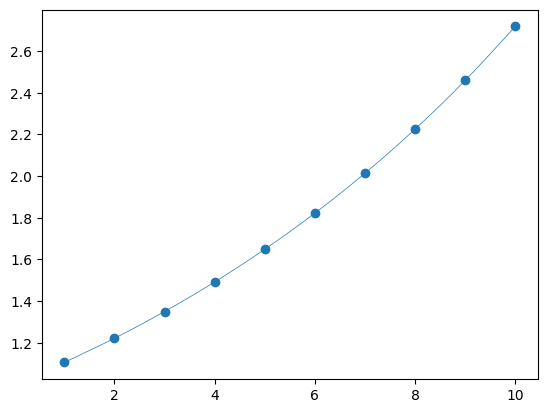

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc20c7dd6c0>

In [63]:
knots = 1:10
data = exp.(0.1*knots)

f = interpolate(data, BSpline(Quadratic(Line(OnGrid()))))

plt.scatter(knots, data, label="values at knots")

knots_fine = LinRange(1, 10, 500)
plt.plot(knots_fine, f.(knots_fine), lw=0.5, label="quadratic interpolation")

In [3]:
β = 10.
μ = +0.2 # Chemical potential
ϵ = +0.1 # Bath energy level
V = -0.1 # Hybridization

# -- Discretization

tmax = 1.
nτ = 10
nτ_fine = 100

contour = kd.ImaginaryContour(β=β)

grid = kd.ImaginaryTimeGrid(contour, nτ)
fine_grid = kd.ImaginaryTimeGrid(contour, nτ_fine)

# -- Exact Diagonalization

H = - μ * op.n("0") + ϵ * op.n("1") +
      V * op.c_dag("1") * op.c("0") + V * op.c_dag("0") * op.c("1")
soi = ked.Hilbert.SetOfIndices([["0"], ["1"]]);
ed = ked.EDCore(H, soi)

idx = ked.Hilbert.IndicesType(["0"])
g = ked.computegf(ed, grid, idx, idx);

g_int = SplineInterpolatedGF(g);

real(g_vals) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
real(g_vals_linear) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
real(g_vals_cubic) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

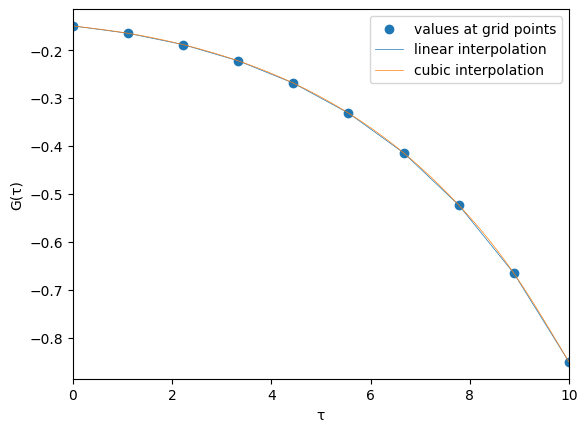

In [4]:
g_vals = [g(tau.bpoint, grid[1].bpoint) for tau in grid]
plt.scatter(kd.imagtimes(grid), imag(g_vals), label="values at grid points")

g_vals_linear = [g(tau.bpoint, grid[1].bpoint) for tau in fine_grid]
plt.plot(kd.imagtimes(fine_grid), imag(g_vals_linear), lw=0.5, label="linear interpolation")

g_vals_cubic = [g_int(tau.bpoint, grid[1].bpoint) for tau in fine_grid]
plt.plot(kd.imagtimes(fine_grid), imag(g_vals_cubic), lw=0.5, label="cubic interpolation")

plt.xlim((0, β))
plt.xlabel("τ")
plt.ylabel("P(τ)")
plt.legend()

@show real(g_vals);
@show real(g_vals_linear);
@show real(g_vals_cubic);

real(g_vals) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
real(g_vals_linear) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
real(g_vals_cubic) = [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0,

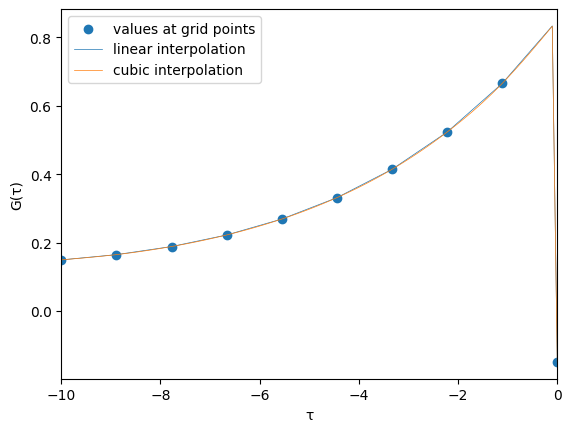

In [5]:
g_vals = [g(grid[1].bpoint, tau.bpoint) for tau in reverse(grid)]
plt.scatter(-reverse(kd.imagtimes(grid)), imag(g_vals), label="values at grid points")

g_vals_linear = [g(grid[1].bpoint, tau.bpoint) for tau in reverse(fine_grid)]
plt.plot(-reverse(kd.imagtimes(fine_grid)), imag(g_vals_linear), lw=0.5, label="linear interpolation")

g_vals_cubic = [g_int(grid[1].bpoint, tau.bpoint) for tau in reverse(fine_grid)]
plt.plot(-reverse(kd.imagtimes(fine_grid)), imag(g_vals_cubic), lw=0.5, label="cubic interpolation")

plt.xlim((-β, 0))
plt.xlabel("τ")
plt.ylabel("P(τ)")
plt.legend()

@show real(g_vals);
@show real(g_vals_linear);
@show real(g_vals_cubic);